<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains instructional material from the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/k2-metadata).*


<!--NAVIGATION-->
< [K2 target index](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [Everest lightcurve metadata](01.06-Everest-lightcurve-metadata.ipynb) >

# Custom aperture information and CAF files

Recently "caf" files have been provided with each campaign's data release notes.  The *caf* files relate two pieces of information-- a given custom target name (e.g. `Comet.67P/Churyumov-Gerasimenko`) with its made-up EPIC ID (e.g. `200081804:200084003`).  More information about target management for custom apertures is described in the [K2 handbook](http://archive.stsci.edu/k2/manuals/k2_handbook.pdf).  

In this Notebook we overhaul all the individual caf files into a single dataframe with additional metadata.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Data Release Notes

First, let's look at the caf files that come in the [Data Release Notes](https://keplerscience.arc.nasa.gov/k2-data-release-notes.html) of each campaign.

In [2]:
! ls -1 ../metadata/raw/custom_apertures/

ktwoc07_caf.csv
ktwoc08_caf.csv
ktwoc10_caf.csv
ktwoc111_caf.csv
ktwoc112_caf.csv
ktwoc12_caf.csv
ktwoc13_caf.csv
ktwoc14_caf.csv
ktwoc91_caf.csv
ktwoc92_caf.csv
trojanCustomApertureC6.csv


In [3]:
path = '../metadata/raw/custom_apertures/'
fns = os.listdir(path)

In [4]:
! head ../metadata/raw/custom_apertures/ktwoc07_caf.csv

#Custom Aperture Number, Target Name
#SET 2016-04-18
200061226,Trojan 2000 QG199
200061227,Trojan 2000 QG199
200061228,Trojan 2000 QG199
200061229,Trojan 2000 QG199
200061230,Trojan 2000 QG199
200061231,Trojan 2000 QG199
200061232,Trojan 2000 QG199
200061233,Trojan 2000 QG199


In [5]:
df_all = pd.DataFrame()

In [6]:
for fn in fns:
    df = pd.read_csv(path+fn, comment='#', names = ['ap_num', 'target'])
    campaign = fn[5:7]
    if campaign == 'nC':
        campaign = 6
    if campaign == '11':
        campaign = fn[5:8]
    df['campaign'] = int(campaign) 
    df_all = df_all.append(df, ignore_index=True)

In [7]:
df_all[df_all.target =='Comet.67P/Churyumov-Gerasimenko'].head()

,ap_num,target,campaign
15844,200081804.0,Comet.67P/Churyumov-Gerasimenko,10
15845,200081805.0,Comet.67P/Churyumov-Gerasimenko,10
15846,200081806.0,Comet.67P/Churyumov-Gerasimenko,10
15847,200081807.0,Comet.67P/Churyumov-Gerasimenko,10
15848,200081808.0,Comet.67P/Churyumov-Gerasimenko,10


In [8]:
df_all.head()

,ap_num,target,campaign
0,200062904.0,TNO.1998 SN165,8
1,200062905.0,TNO.1998 SN165,8
2,200062906.0,TNO.1998 SN165,8
3,200062907.0,TNO.1998 SN165,8
4,200062908.0,TNO.1998 SN165,8


In [9]:
df_all.campaign.value_counts()

6      19261
111    18601
112    18430
12     16730
10     13186
14      9130
8       5752
13      4736
92      2674
91      2542
7       1602
Name: campaign, dtype: int64

The Data Release Notes do not have CAF files for all campaigns.  Let's use our internal tools at K2 to make sure we have access to all caf files.

## Obtain all custom aperture ids from internal K2 caf files
This concatenated list of caf files is called the **golden CAF** by research scientist Jeff Van-Cleve (*aka* JVC).   
See Kepler/K2 Science Office internal documents on JIRA ticket KSO-568.

In [10]:
! head -n 5 ../metadata/temp/golden_caf_18010323.txt


2002 GV31
33 CET
42 CET
60 PSC


In [11]:
jvc_caf = pd.read_csv('../metadata/temp/golden_caf_18010323.txt', names=['jvc_name'])
jvc_caf['in_JVC'] = 1
jvc_caf.head()

,jvc_name,in_JVC
0,2002 GV31,1
1,33 CET,1
2,42 CET,1
3,60 PSC,1
4,73 PSC,1


In [12]:
spot_check = pd.merge(df_all.target.value_counts().to_frame(), jvc_caf, 
                      how='outer', left_index=True, right_on='jvc_name', indicator=True)

In [13]:
spot_check.head()

,target,jvc_name,in_JVC,_merge
391,3496.0,C9 Microlens Survey,NaN,left_only
115,2999.0,Asteroid.Trojan.Leucus,1.0,both
149,2200.0,Comet.67P/Churyumov-Gerasimenko,1.0,both
65,1700.0,Asteroid.Trojan.2001 DU87,1.0,both
75,1592.0,Asteroid.Trojan.2001 SE182,1.0,both


In [14]:
spot_check._merge.value_counts()

both          313
right_only     79
left_only      76
Name: _merge, dtype: int64

What are the targets that only I have, but JVC does not?

In [15]:
left_only = spot_check[spot_check._merge=='left_only'].jvc_name[1:].values #skip the first one
df_all[df_all.target.isin(left_only)].reset_index(drop=True).head(10)

,ap_num,target,campaign
0,200041889.0,10989,6
1,200041890.0,10989,6
2,200041891.0,10989,6
3,200041892.0,10989,6
4,200041893.0,10989,6
5,200041894.0,10989,6
6,200041895.0,10989,6
7,200041896.0,10989,6
8,200041897.0,10989,6
9,200041898.0,10989,6


These stars appear in my compiled list, but not in JVC's.  They are probably bright stars or asteroids that were given different names in campaigns 6 and 7.  
What are the stars that JVC has, but I do not?

In [16]:
spot_check[spot_check._merge=='right_only'].head()

,target,jvc_name,in_JVC,_merge
0,NaN,2002 GV31,1.0,right_only
6,NaN,ARP,1.0,right_only
136,NaN,C9 Microlense Survey,1.0,right_only
151,NaN,Comet C/2013 A1 (Siding Springs),1.0,right_only
180,NaN,M35,1.0,right_only


Some objects in the DRN-released caf files have no names?  The JVC "Golden Caf" lacks the needed aperture ids.  Let's retrieve all the original raw caf files.

## Concatenate all internal caf files

I retrieved all the *internal caf files* from the SVN repository following the instructions in JVC's comments on 03/Jan/18 3:42 PM to the `KSOP-3027` ticket.  

Here are the filenames and campaign names.

In [17]:
fn_dict = {'15298_sethomps_ksop2395/kplr2015289145200_c05_caf.txt': 5,
'17310_jvancleve_ksop2981/kplr2017307121200_c14_caf.txt': 14,
'16020_sethomps_ksop2541/kplr2016020145500_c06_caf.txt': 6,
'15070_sethomps_caf_ksop2236/kplr2015065130800_c02_caf.txt': 2,
'17226_jevancle_ksop2964/kplr2017215094200_c13_caf.txt': 13,
'16251_jevancle_ksop2732/kplr2016243125800_c092_caf.txt': 92,
'16251_jevancle_ksop2732/kplr2016238115500_c091_caf.txt': 91,
'15154_sethomps_ksop2328/kplr2015156135700_c03_caf.txt': 3,
'16334_jevancle_ksop2801/kplr2016334142100_c10_caf.txt': 10,
'16102_sethomps_ksop2627/kplr2016097162800_c07_caf.txt': 7,
'17129_jevancle_ksop2850/kplr2017124153300_c112_caf.txt': 112,
'17129_jevancle_ksop2850/kplr2017124153300_c111_caf.txt': 111,
'14324_sethomps_ksop2061/kplr2014324163300_c01_caf.txt': 1,
'14238_sethomps_ksop2004/ktwo2014225112200_c00_caf.txt': 0,
'16174_jevancle_ksop2670/kplr2016174093800_c08_caf.txt': 8,
'15249_sethomps_ksop2294/kplr2015232163700_c04_caf.txt': 4,
'17200_jevancle_ksop2955/kplr2017187134900_c12_caf.txt': 12}

# There's a repeat of campaign 3...  assume the newer one is correct?
#'./15154_sethomps_ksop2328/kplr2015154104800_c03_caf.txt': 3,

In [18]:
path = '../metadata/temp/svn/caf/'

In [19]:
! tail ../metadata/temp/svn/caf/17226_jevancle_ksop2964/kplr2017215094200_c13_caf.txt

247220058|1||||Bright Stars
247649941|1||||Bright Stars SC
246810368|1||||Bright Stars SC
210528045|1||||Bright Stars SC
210956961|1||||Bright Stars SC
210989874|1||||Bright Stars SC
246721980|1||||Bright Stars SC
210548567|1||||Bright Stars SC
247117838|1||||Bright Stars SC
210950988|1||||Bright Stars SC


On Feb. 1, 2018, JVC sent an me an email describing the column info:

>Column 0: Custom KepId

>Column 1, type of target:
1. Single star in EPIC -- this includes all galaxies which are in EPIC
2. Engineering data (EN) -- in practice ARPs only
3. Large swatch of sky., no known target (STC, EXBA) -- includes galaxies specified by (ra, dec) bounds not EPIC ID (like NGC3412 in c14) & superstamps
4. Single "star" not in the KIC -- usually a small galaxy
5. Solar System object

>Column 2: EPIC ID for target in EPIC which was assigned a custom aperture (bright star disks).  C14 example:
200182925|1|201698740|||Bright Stars

>Column 3, 4: Ra, Dec for "center" of type 3 or 4 targets.  C14 example:
200183086|3||162.72210|13.41210|Large Galaxies.NGC3412

>Column 5: Custom label, used in K2 data retrieval 'Target Type' and 'SubType'

In [20]:
col_names = ['ap_num','targtype', 'EPIC_ID', 'custom_RA', 'custom_DEC', 'object_name']

We'll read in all the cad files into a single dataframe.

In [21]:
caf_all = pd.DataFrame()

In [22]:
for fn_key, fn_val in fn_dict.items():
    print(fn_val, end=' ')
    df = pd.read_csv(path+fn_key, sep='|', names = col_names)
    df['campaign'] = int(fn_val)
    caf_all = caf_all.append(df, ignore_index=True)

5 14 6 2 13 92 91 3 10 7 112 111 1 0 8 4 12 

In [23]:
caf_all.shape

(119679, 7)

In [24]:
caf_all.tail()

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
119674,200164263,5,NaN,NaN,NaN,Comet.Chiron,12
119675,200164264,5,NaN,NaN,NaN,Comet.Chiron,12
119676,200164265,5,NaN,NaN,NaN,Comet.Chiron,12
119677,200164266,5,NaN,NaN,NaN,Comet.Chiron,12
119678,246199087,1,NaN,NaN,NaN,TRAPPIST-1,12


What are the targets with the most number of custom apertures?

In [25]:
caf_all.object_name.value_counts().head()

C9 Microlense Survey                3496
Asteroid.Trojan.Leucus              2999
Comet C/2013 A1 (Siding Springs)    2583
Comet.67P/Churyumov-Gerasimenko     2200
Asteroid.Trojan.2001 DU87           1700
Name: object_name, dtype: int64

I spot-checked the "Golden Caf" that JVC sent, and my own pandas-based analysis and we arive at the same list.

## Make an easy-to-use golden caf with extra metadata

This section gets a little messy with pandas-*fu*, but, it works.

In [26]:
caf_ap_range1 = pd.pivot_table(caf_all, index='object_name', values=['ap_num'], aggfunc=np.min)
caf_ap_range1 = caf_ap_range1.reset_index().rename_axis({'ap_num':'ap_start'}, axis=1)
caf_ap_range2 = pd.pivot_table(caf_all, index='object_name', values=['ap_num'], aggfunc=np.max)
caf_ap_range2= caf_ap_range2.reset_index().rename_axis({'ap_num':'ap_end'}, axis=1)
caf_ap_range = pd.merge(caf_ap_range1, caf_ap_range2, how='left', on='object_name')
caf_ap_range.head()

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  
/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  after removing the cwd from sys.path.


,object_name,ap_start,ap_end
0,2002 GV31,200001049,200001049
1,33 CET,220291034,220291034
2,42 CET,220186864,220186864
3,60 PSC,220498764,220498764
4,73 PSC,220448752,220448752


Applying a min aggregating function is the same as taking a random element when all elements are equal.

In [27]:
c2_objname_raw = pd.pivot_table(caf_all, index='EPIC_ID', values=['object_name'], aggfunc=np.min)
c2_objname = c2_objname_raw.reset_index()
c2_objname.head()

,EPIC_ID,object_name
0,201594287.0,Bright Stars.P04_LEO
1,201646904.0,Large Galaxies
2,201661880.0,Large Galaxies
3,201698740.0,Bright Stars.58_LEO
4,201885041.0,Star.Wolf-359


We'll need a data frame of the EPIC ID counts for later:

In [28]:
caf_counts_out = caf_all.object_name.value_counts().to_frame().reset_index().rename_axis({'index':'obj_name', 'object_name':'count'}, axis=1)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """Entry point for launching an IPython kernel.


In [29]:
caf_counts_out.head()

,obj_name,count
0,C9 Microlense Survey,3496
1,Asteroid.Trojan.Leucus,2999
2,Comet C/2013 A1 (Siding Springs),2583
3,Comet.67P/Churyumov-Gerasimenko,2200
4,Asteroid.Trojan.2001 DU87,1700


We'll also need a dataframe of which campaigns the objects appear in:

In [30]:
by_campaign = pd.pivot_table(caf_all, index='object_name', values=['campaign'], aggfunc=np.unique).reset_index()
by_campaign.head()

,object_name,campaign
0,2002 GV31,1
1,33 CET,8
2,42 CET,8
3,60 PSC,8
4,73 PSC,8


# Merge into a single, informative table.

We'll combine the metadata in a few steps:


|identifier|Columns added|
|--|--|
| `out1` | obj_name, count, ap_start, ap_end, diff|
| `out2` | EPIC_ID | 
| `out3` | Campaign appearances | 
| `out4` | Main type and subtype classifications | 
| `out5` | New names for ambiguous labels | 

### Add custom aperture start and end.

In [31]:
out1 = pd.merge(caf_counts_out, 
                caf_ap_range.rename_axis({'object_name':'obj_name'}, axis=1),
                how='outer', left_on='obj_name', right_on='obj_name', indicator=False)
out1['diff'] = out1.ap_end - out1.ap_start +1
out1.head()

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,obj_name,count,ap_start,ap_end,diff
0,C9 Microlense Survey,3496,200069411,200071158,1748
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200
4,Asteroid.Trojan.2001 DU87,1700,200113657,200134731,21075


### Add an "EPIC_ID" column, when available

In [32]:
out2 = pd.merge(out1, 
                c2_objname.rename_axis({'object_name':'obj_name'}, axis=1),
                how='left', on='obj_name', indicator=False)
out2.head()

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,obj_name,count,ap_start,ap_end,diff,EPIC_ID
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964,NaN
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583,NaN
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200,NaN
4,Asteroid.Trojan.2001 DU87,1700,200113657,200134731,21075,NaN


### Add a campaign column

In [33]:
out3 = pd.merge(out2, by_campaign.rename(columns={'object_name':'obj_name'}), how='outer', on='obj_name')
out3.head(5)

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN,"[91, 92]"
1,Asteroid.Trojan.Leucus,2999,200125327,200145290,19964,NaN,"[111, 112]"
2,Comet C/2013 A1 (Siding Springs),2583,200001787,200004369,2583,NaN,2
3,Comet.67P/Churyumov-Gerasimenko,2200,200081804,200084003,2200,NaN,10
4,Asteroid.Trojan.2001 DU87,1700,200113657,200134731,21075,NaN,"[111, 112]"


### Add category columns

We could set categories with a dictionary, or many other ways.  I decided to use control flow because the search order matters-- we want to handle instances where substrings appear in order of shorter substrings.

In [34]:
def cat_picker(col, num=0):
    splits = col.split('.')
    n_splits = len(splits)
    out=['null', 'null']
    if n_splits == 1:
        out=['null', col]
    if col.upper().find('TROJAN') != -1:
        out=['asteroid-Trojan', col[col.upper().find('TROJAN')+6:]]
    if col.upper().find('ASTEROID.TROJAN') != -1:
        out=['asteroid-Trojan', splits[2]]
    if col.upper().find('ASTEROID.HILDA') != -1:
        out=['asteroid-Hilda', splits[2]]
    if (col.upper().find('COMET') != -1) & (n_splits==1):
        out=['comet', col[col.upper().find('COMET'):]]
    if col.upper().find('COMET.') != -1:
        out=['comet', splits[1]]
    if col.upper().find('MOON') != -1:
        out=['moon', splits[1]]
    if col.upper().find('CLUSTER') != -1:
        out=['cluster', splits[1]]
    if col.upper().find('LARGE GALAXIES') != -1:
        out=['Large Galaxies', 'null']
    if col.upper().find('LARGE GALAXIES.') != -1:
        out=['Large Galaxies', splits[1]]
    if col.upper().find('TNO') != -1:
        out=['TNO', col[col.upper().find('TNO')+3:]]
    if col.upper().find('TNO.') != -1:
        out=['TNO', splits[1]]
    if col in ['M4', 'M35', 'M67', 'Ruprecht 147', 'M8 Lagoon Nebula', 'M80']:
        out=['cluster', col]
    if (col[0:3] == 'MOA') or (col[0:4]=='OGLE'):
        out=['microlensing-events', col]
    if col in ['Neptune']:
        out=['planet', col]
    if col in ['PLANET.Uranus']:
        out=['planet', splits[1]]
    if col in ['Pluto']:
        out=['TNO', col]
    if col.upper().find('BRIGHT STARS.') != -1:
        out=['bright stars', splits[1]]
    if col == 'Dark Clouds':
        out=['C9 Dark Clouds', 'null']
    if col.upper().find('IC 1613') != -1:
        out=['Large Galaxies', 'IC 1613']
    if col=='2002 GV31':
        out=['TNO', '2002 GV31']
    if col in ['TRAPPIST-1', 'Star.Wolf-359']:
        out=['Star', col]
    if col in ['60 PSC', '42 CET', '80 PSC', '73 PSC', 
               'EPS PSC', 'WW PSC','ZET PSC', 'HR 243', '33 CET']:
        out=['bright stars', col]
    if col=='Ongoing_Microlens_Events_C11':
        out = ['C11 Microlensing Events', 'null']
    if col=='HR 161':
        out=['bright stars', 'HR 161']
    if col=='Asteroid.373':
        out=['asteroid-Main Belt', '373 Melusina']
    if col=='C9 Microlense Survey':
        out=['C9 Microlens Survey', 'null']
    return out[num]

In [35]:
out4 = out3.copy()

In [36]:
out4['main_type'] = out4.obj_name.apply(cat_picker,num=0)
out4['sub_type'] = out4.obj_name.apply(cat_picker,num=1)

In [37]:
#pd.options.display.max_rows = 999

In [38]:
#out4.main_type.value_counts()

In [39]:
out4.tail()

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign,main_type,sub_type
433,2002 GV31,1,200001049,200001049,1,NaN,1,TNO,2002 GV31
434,HR 161,1,220323358,220323358,1,NaN,8,bright stars,HR 161
435,80 PSC,1,220448416,220448416,1,NaN,8,bright stars,80 PSC
436,42 CET,1,220186864,220186864,1,NaN,8,bright stars,42 CET
437,Large Galaxies.NGC 3279,1,200182983,200182983,1,NaN,14,Large Galaxies,NGC 3279


In [40]:
#out4[out4.main_type == 'null']

### Replace ambiguous labels with unique EPIC ID names

Ambiguous labels are hard to work with, they should be the "type" label.

In [41]:
ambiguous_labels = ['Bright Stars', 'Bright Custom', 'Isolated Stars', 'Bright Stars SC']

In [42]:
out5 = out4.copy()

In [43]:
to_keep = ~out5.obj_name.isin(ambiguous_labels+['ARP'])
out5 = out5[to_keep]
out5['new_obj_name'] = out5['obj_name'].copy()

In [44]:
def transform_caf_subset(df, main_type='null', sub_type='null'):
    '''Replaces ambiguous names with unique names for Golden Caf'''
    keep_cols = ~df.columns.isin(['targtype', 'EPIC_ID', 'custom_RA', 'custom_DEC'])
    df = df[df.columns[keep_cols]].reset_index(drop=True)
    df['ap_start'] = df['ap_num']
    df['ap_end'] = df['ap_num']
    df['EPIC_ID'] = df['ap_num']
    df['new_obj_name'] = df['ap_num']
    df['count'] = 1
    df['diff'] = 1
    df['main_type'] = main_type
    df['sub_type'] = sub_type
    df = df.rename(columns={'object_name':'obj_name'})
    df = df.drop(['ap_num'], axis=1)
    
    return df

In [45]:
for label in ambiguous_labels:
    print(label)
    labelled_subset = caf_all[caf_all.object_name == label]
    out_subset = transform_caf_subset(labelled_subset, main_type=label, sub_type='null')
    out5 = pd.concat([out5, out_subset], axis=0, ignore_index=True)

Bright Stars
Bright Custom
Isolated Stars
Bright Stars SC


In [46]:
caf_all.tail()

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
119674,200164263,5,NaN,NaN,NaN,Comet.Chiron,12
119675,200164264,5,NaN,NaN,NaN,Comet.Chiron,12
119676,200164265,5,NaN,NaN,NaN,Comet.Chiron,12
119677,200164266,5,NaN,NaN,NaN,Comet.Chiron,12
119678,246199087,1,NaN,NaN,NaN,TRAPPIST-1,12


In [47]:
caf_all.object_name.value_counts().to_csv('temp.csv')

In [48]:
out5.main_type.value_counts()

asteroid-Trojan            156
microlensing-events         72
Bright Stars                71
Large Galaxies              66
TNO                         54
Bright Custom               50
asteroid-Hilda              30
bright stars                17
comet                       13
cluster                     11
Bright Stars SC              9
Isolated Stars               8
moon                         6
Star                         2
planet                       2
C9 Dark Clouds               1
C9 Microlens Survey          1
C11 Microlensing Events      1
asteroid-Main Belt           1
Name: main_type, dtype: int64

In [49]:
out_col_order = ['obj_name', 'campaign', 'ap_start', 'ap_end', 'count', 'EPIC_ID', 
                 'main_type', 'sub_type','new_obj_name']

In [50]:
out5 = out5[out_col_order]

### The campaigns should be strings not lists

In [51]:
multi_campaigns = out5.campaign.apply(type) == np.ndarray

In [52]:
format_func = lambda vals: np.array2string(vals, separator='|')[1:-1]

In [53]:
out6 = out5.copy()

In [54]:
out6.campaign[multi_campaigns] = out5.campaign[multi_campaigns].apply(format_func)

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Make them all strings

In [55]:
out6.campaign = out6.campaign.astype(str)

In [56]:
out6.head()

,obj_name,campaign,ap_start,ap_end,count,EPIC_ID,main_type,sub_type,new_obj_name
0,C9 Microlense Survey,91|92,200069411,200071158,3496,NaN,C9 Microlens Survey,null,C9 Microlense Survey
1,Asteroid.Trojan.Leucus,111|112,200125327,200145290,2999,NaN,asteroid-Trojan,Leucus,Asteroid.Trojan.Leucus
2,Comet C/2013 A1 (Siding Springs),2,200001787,200004369,2583,NaN,comet,Comet C/2013 A1 (Siding Springs),Comet C/2013 A1 (Siding Springs)
3,Comet.67P/Churyumov-Gerasimenko,10,200081804,200084003,2200,NaN,comet,67P/Churyumov-Gerasimenko,Comet.67P/Churyumov-Gerasimenko
4,Asteroid.Trojan.2001 DU87,111|112,200113657,200134731,1700,NaN,asteroid-Trojan,2001 DU87,Asteroid.Trojan.2001 DU87


In [57]:
out6.to_csv('../metadata/temp/temp_caf_stats.csv', index=False)

In [58]:
! open ../metadata/temp/

# More todo

1. ~~Check all EPIC ids less than the custom aperture number threshold~~
2. ~~Check objects with more files than difference between high and low custom numbers.~~
3. ~~Complete custom categorization~~
4. ~~Manually input names for ambiguous labels~~
5. ~~Fix the Campaign from lists to strings.~~

## Check all EPIC ides less than the custom aperture number threshold

Huber et al. 2016 Table 3 defines the EPIC numbers for custom targets and K2 targets:

> `200M–201M` K2 Custom Aperture Targets  
> `>201M` EPIC (K2 Catalog Targets)

In [57]:
custom_ids = caf_all.ap_num < 201000000

In [58]:
custom_ids.sum(), (~custom_ids).sum(), len(custom_ids)

(119508, 171, 119679)

OK, so 171 names are *not* in the custom id range.  These are likely bright stars or known galaxies.

In [59]:
caf_all[~custom_ids].object_name.unique()

array(['Star.Wolf-359', 'Bright Stars', 'Bright Stars SC',
       'Bright Custom', 'Large Galaxies', 'EPS PSC', 'ZET PSC', '80 PSC',
       '33 CET', '60 PSC', '73 PSC', 'WW PSC', '42 CET', 'HR 243',
       'HR 161', 'TRAPPIST-1'], dtype=object)

Indeed, that guess was correct.

What about the largest custom id issued?  Is it equal to the total number of custom apertures?

In [60]:
caf_all[custom_ids].ap_num.max(), caf_all.ap_num.min()

(200183086, 200000811)

There might be some custom apertures in the engineering run possessing 20000000-2000811 which we don't have here...

In [61]:
N_custom_aps = caf_all[custom_ids].ap_num.max() - caf_all.ap_num.min()

In [62]:
N_custom_aps

182275

So about 182,275 custom apertures have been issued, assuming all custom apertures are actually delivered.  How many are in the caf all list?

In [63]:
caf_all.shape

(119679, 7)

We only have 119,679, naively suggesting some missing custom apertures:

In [64]:
N_missing = 182275 - 119679
N_missing

62596

In [65]:
'Missing {:0.1%} of custom apertures'.format(N_missing/N_custom_aps)

'Missing 34.3% of custom apertures'

I suspect these are engineering apertures or something, making them escape our tracking.

## Check objects with more files than difference between high and low custom numbers.

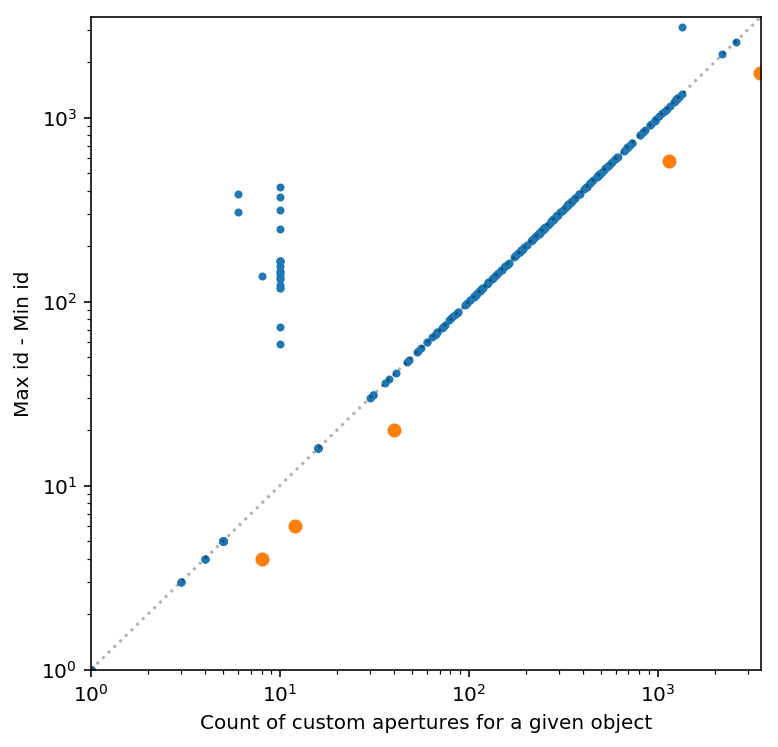

In [66]:
plt.figure(figsize=(6,6))
plt.plot(out3['count'], out3['diff'], '.')
plt.xscale('log')
plt.yscale('log')
plt.plot([1,3500], [1, 3500], 'k:', alpha=0.3)
plt.xlim(1, 3500)
plt.ylim(1, 3500)
plt.xlabel('Count of custom apertures for a given object')
plt.ylabel('Max id - Min id')

repeat_ids = out3['count'] > out3['diff']
plt.plot(out3['count'][repeat_ids], out3['diff'][repeat_ids], 'o')

Numbers below the line have more actual custom id counts than the difference between their maximum and minimum custom id number, suggesting some repeats.

In [67]:
out3[repeat_ids]

,obj_name,count,ap_start,ap_end,diff,EPIC_ID,campaign
0,C9 Microlense Survey,3496,200069411,200071158,1748,NaN,"[91, 92]"
20,TNO.Quaoar,1154,200068780,200069356,577,NaN,"[91, 92]"
313,M8 Lagoon Nebula,40,200071160,200071179,20,NaN,"[91, 92]"
328,Dark Clouds,12,200069381,200069386,6,NaN,"[91, 92]"
350,Isolated Stars,8,200069387,200069390,4,NaN,"[91, 92]"


So for example in the last column:

In [68]:
200069390 - 200069387

3

Is less than the total count of "8".

In [69]:
caf_all[caf_all.object_name == 'Isolated Stars']

,ap_num,targtype,EPIC_ID,custom_RA,custom_DEC,object_name,campaign
38071,200069387,4,NaN,NaN,NaN,Isolated Stars,92
38072,200069388,4,NaN,NaN,NaN,Isolated Stars,92
38073,200069389,4,NaN,NaN,NaN,Isolated Stars,92
38074,200069390,4,NaN,NaN,NaN,Isolated Stars,92
40809,200069387,4,NaN,NaN,NaN,Isolated Stars,91
40810,200069388,4,NaN,NaN,NaN,Isolated Stars,91
40811,200069389,4,NaN,NaN,NaN,Isolated Stars,91
40812,200069390,4,NaN,NaN,NaN,Isolated Stars,91


No big deal... It looks like all of these are in two halves of campaign 9, doubling their count. 

In [70]:
out3[repeat_ids]['diff'] * 2.0

0      3496.0
20     1154.0
313      40.0
328      12.0
350       8.0
Name: diff, dtype: float64

Solves that problem!

<!--NAVIGATION-->
< [K2 target index](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [Everest lightcurve metadata](01.06-Everest-lightcurve-metadata.ipynb) >